In [37]:
import warnings
warnings.filterwarnings('ignore')
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [38]:
heart_data = pd.read_csv("./data/heart_failure_clinical_records_dataset.csv")
display(heart_data)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [39]:
scaler = StandardScaler()
heart_data_std = scaler.fit_transform(heart_data.iloc[:,:-1])

In [40]:
x_train, x_test, y_train, y_test = train_test_split(heart_data_std, heart_data.DEATH_EVENT, test_size = 0.2, random_state=0)

In [41]:
x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

torch.Size([239, 12]) torch.Size([60, 12]) torch.Size([239]) torch.Size([60])


In [42]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        # can also use nn.Sequential
        self.layer1 = nn.Linear(in_features=12, out_features=5)
        self.layer2 = nn.Linear(in_features=5, out_features=1)
    
    def forward(self, x):
        return self.layer2(self.layer1(x))

In [43]:
# option 2
model = nn.Sequential(nn.Linear(in_features=12, out_features=5), nn.Linear(in_features=5, out_features=1))

In [44]:
# binary bross entropy
loss_fn = nn.BCEWithLogitsLoss()

# SGD
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [45]:
def compute_accuracy(y_true, y_pred):
    tp_tn = torch.eq(y_true, y_pred).sum().item()
    acc = (tp_tn / len(y_pred)) * 100 
    return acc

def plot_acc(train_acc_list, test_acc_list):
        plt.figure(figsize=(5,5))
        plt.plot(train_acc_list, label='train acc')
        plt.plot(test_acc_list, label='test acc')

        plt.legend()
        plt.show()

Epoch: 0, Loss: 0.67699, Accuracy: 59.41% | Test loss: 0.74250, Test acc: 40.00%
Epoch: 100, Loss: 0.58167, Accuracy: 72.38% | Test loss: 0.64866, Test acc: 63.33%
Epoch: 200, Loss: 0.51837, Accuracy: 76.99% | Test loss: 0.58705, Test acc: 66.67%
Epoch: 300, Loss: 0.46932, Accuracy: 79.92% | Test loss: 0.53825, Test acc: 68.33%
Epoch: 400, Loss: 0.43265, Accuracy: 81.59% | Test loss: 0.50069, Test acc: 73.33%
Epoch: 500, Loss: 0.40682, Accuracy: 82.43% | Test loss: 0.47400, Test acc: 76.67%
Epoch: 600, Loss: 0.38928, Accuracy: 83.26% | Test loss: 0.45645, Test acc: 76.67%
Epoch: 700, Loss: 0.37748, Accuracy: 84.94% | Test loss: 0.44575, Test acc: 78.33%
Epoch: 800, Loss: 0.36952, Accuracy: 85.77% | Test loss: 0.43984, Test acc: 78.33%
Epoch: 900, Loss: 0.36409, Accuracy: 85.36% | Test loss: 0.43715, Test acc: 78.33%


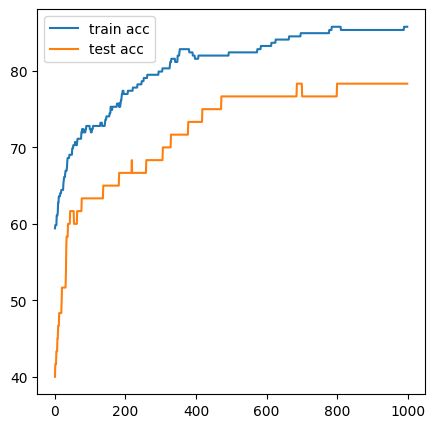

In [46]:
# model training 
torch.manual_seed(0)
epochs = 1000
train_acc_list = []
test_acc_list = []

for epoch in range(epochs):

    model.train()
    y_pred = model(x_train).squeeze()
    loss = loss_fn(y_pred, y_train) 

    # calc acc
    acc = compute_accuracy(y_true=y_train, y_pred=torch.round(torch.sigmoid(y_pred))) 
    train_acc_list.append(acc)

    # training
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    model.eval()
    
    # inference mode for prediction on the test data
    with torch.inference_mode():
        
        test_logits = model(x_test).squeeze() 
        test_loss = loss_fn(test_logits, y_test)
        test_acc = compute_accuracy(y_true=y_test, y_pred=torch.round(torch.sigmoid(test_logits)))
        test_acc_list.append(test_acc)
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

plot_acc(train_acc_list, test_acc_list)